# Выбираем авто выгодно
## Описание задачи
Построить модель, которая будет предсказывать стоимость автомобиля по его характеристикам.

### Описание датасета по условиям задачи

Переменные, которые содержит датасет:
1. bodyType - тип кузова
2. brand - марка автомобиля
3. car_url - адрес страницы с объявлением
4. color - цвет автомобиля
5. complectation_dict - словарь с параметрами комплектации авто
6. description - описание автомобиля
7. engineDisplacement - объем двигателя
8. enginePower - мощность двигателя
9. equipment_dict - словарь оснащения авто
10. fuelType - тип топлива
11. image - изображение
12. mileage - пробег
13. modelDate - дата выпуска модели
14. model_info - информация о модели
15. model_name - название модели
16. name - имя
17. numberOfDoors - кол-во дверей
18. parsing_unixtime - когда был произведен парсинг данных
19. priceCurrency - валюта
20. productionDate - год производства
21. sell_id
22. super_gen - словарь с дополинтельной информацией
23. vehicleConfiguration - конфигурация транспортного средства
24. vehicleTransmission - трансмиссия
25. vendor - страна-изготовитель
26. Владельцы - кол-во владельцев
27. Владение - период владения
28. ПТС
29. Привод
30. Руль
31. Состояние
32. Таможня

# Загрузка необходимых библиотек и функций
## Библиотеки

In [1]:
from IPython.core.display import display, HTML

import pandas as pd
import pandas_profiling
from pandas_profiling import ProfileReport
from pandas import Series
import numpy as np
from numpy import mean
import json
import collections

from datetime import datetime, date, timedelta

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from sklearn.feature_selection import f_classif, mutual_info_classif, VarianceThreshold, SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
from sklearn.ensemble import StackingRegressor

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import kneighbors_graph
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics.cluster import completeness_score, v_measure_score

from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_extraction.text import CountVectorizer

from scipy.stats import randint
import statsmodels.api as sm

from imblearn.pipeline import Pipeline

from math import log as log
import os

from itertools import combinations
from scipy.stats import ttest_ind

import re

In [2]:
import warnings; warnings.simplefilter('ignore')

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

In [5]:
RANDOM_SEED = 42

## Классы и Функции

In [6]:
# Класс для обработки признака времени владения автомобилем.

class OwnershipPeriod():
    def __init__(self):
        self.pattern = re.compile('((\d+) (года|год|лет)){0,1}( и ){0,1}((\d+) (месяц)){0,1}')
        
    def get_months_from_ownership_period(self, x):
        '''Функция для подсчета кол-ва месяцев владения автомобилем, осуществляется через 
        преобразование кол-ва лет и месяцев в кол-во месяцев.'''
        search_res = self.pattern.search(str(x))

        years = 0
        months = 0

        if search_res.group(2):
            years = int(search_res.group(2))
        if search_res.group(6):
            months = int(search_res.group(6))

        return years*12 + months

In [7]:
def profile_report(df):
    '''Функция для вызова профайл-отчета о датафрейме'''
    
    if df is None:
        raise TypeError(nameof(df))

    profile = df.profile_report(
        title='Car Price prediction',
        progress_bar=False,
        correlations={
            'pearson': {'calculate': True},
            'spearman': {'calculate': True},
            'kendall': {'calculate': True},
            'phi_k': {'calculate': True},
            'cramers': {'calculate': True},
        },
        interactions={
            'continuous': True,
            'targets': []
        },
        missing_diagrams={
            'heatmap': True,
            'dendrogram': True,
            'matrix': True
        },
        vars={
            'cat': {'n_obs': 10}
        }
    )

    return profile

In [8]:
def asfloat(x, zero_if_none=False):
    '''Функция для перевода значения в float.'''
    if x is None or x == '':
        if zero_if_none:
            return 0
        else:
            return None
    else:
        return float(x)

In [9]:
def asdict(x):
    '''Функция для замены значений в словаре.'''
    if type(x) != str:
        return None
    
    return eval(x.replace('true', 'True').replace('false', 'False'))

In [10]:
def labeling(col):
    '''Функция для кодирования признаков.'''
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

In [11]:
def get_log(df, col):
    '''Функция для логарифмирования признака'''
    
    return df[col].apply(lambda x: np.log(x + 1))

In [12]:
# Класс для исследования числовых признаков

class NumericInspector():
    def __init__(self, df):
        self.df = df

    def _prepare_series(self, column, log):
        return self.df[column] if log == False else get_log(self.df, column)

    def _show_plots(self, df_series, title, size):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3*size, size))

        fig = sm.qqplot(df_series, fit=True, line='45', ax=ax1)

        fig.suptitle(title, fontsize=20)

        ax2.hist(df_series, bins=20, histtype='bar', align='mid', rwidth=0.8)

        ax3.boxplot(df_series, vert=False)

        ax1.set_title('QQ-plot')
        ax2.set_title('Histogram')
        ax3.set_title('Boxplot')
        
        plt.show()

    def _boundaries(self, df_series):
        q1 = df_series.quantile(q=0.25, interpolation="midpoint")
        q3 = df_series.quantile(q=0.75, interpolation="midpoint")
        IQR = q3 - q1

        return q1 - 1.5*IQR, q3 + 1.5*IQR, q1, q3, IQR

    def _outliers(self, df_series):
        minb, maxb, q1, q3, IQR = self._boundaries(df_series)

        return len(df_series[df_series < minb]) + len(df_series[df_series > maxb])

    def _display_result_info(self, df_series):
        minb, maxb, q1, q3, IQR = self._boundaries(df_series)
        
        display(HTML(
            f'''
                <div style="text-align: center; margin-bottom: 20px;"> 
                    --- <span style="font-weight: bold;">q1: </span>
                    {np.round(q1, 2)},
                    <span style="font-weight: bold;">q3: </span>
                    {np.round(q3, 2)},
                    <span style="font-weight: bold;">IQR: </span>
                    {np.round(IQR, 2)},
                    <span style="font-weight: bold;">Boundaries: </span>
                    {np.round((minb, maxb), 2)}, 
                    <span style="font-weight: bold;">Outliers: </span>
                    {self._outliers(df_series)} --- 
                </div>
            '''))

    def inspect(self, column, size=5, with_log=True, title=None, title_for_log=None):
        # дефолтное отображение
        title_wl = title if title is not None else f"Inspection for '{column}' without 'log'"
        df_series = self._prepare_series(column, log=False)
        self._show_plots(df_series, title_wl, size)
        self._display_result_info(df_series)

        if with_log:
            # с логарифмированием
            title_fl = title_for_log if title_for_log is not None else f"Inspection for '{column}' with 'log'"
            try:
                df_series = self._prepare_series(column, log=True)
                self._show_plots(df_series, title_fl, size)
                self._display_result_info(df_series)
            except:
                plt.close()
                display(HTML(
                    f'''
                    <div style="text-align: center; margin-bottom: 22px;">
                        <span style="font-size: 20px; font-weight: bold;">Логарифмирование признака не удалось! :( </span>
                    </div>
                    '''))

        display(HTML('<hr style="width:90%; height:2px; border-width:0; color:gray; background-color:gray; margin-bottom: 30px;">'))

In [13]:
def mape(y_true, y_pred):
    '''Функция для определения метрики'''
    return np.mean(np.abs((y_pred-y_true)/y_true))

## Осмотр и предварительный анализ данных

В рамках задания были предоставлены тестовые данные. Для получения обучающей выборки был произведен парсинг данных с сайта auto.ru, в папке на github представлен отдельный ноутбук с кодом для парсинга.

In [14]:
train = pd.read_csv('parsed_data.csv')
test = pd.read_csv('test.csv')

display(train.head(), test.head())

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price
0,родстер,AC,https://auto.ru/cars/used/sale/ac/cobra/110091...,белый,NaN,Shelby AC Cobra\nОдна из самых быстрых Кобр\nС...,4.9 LTR,340 N12,{},бензин,NaN,33000,1999,"{'code': 'COBRA', 'name': 'Cobra', 'ru_name': ...",COBRA,4.9 MT (340 л.с.),2,1623674075,RUB,1999,1100919382,"{'id': '20465488', 'displacement': 4942, 'engi...",ROADSTER MECHANICAL 4.9 LTR,механическая,EUROPEAN,3 или более,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен,11000000.0
1,родстер,AC,https://auto.ru/cars/used/sale/ac/cobra/108956...,красный,NaN,Не участвовала в ДТП. очень шустрый легкий езд...,4.9 LTR,326 N12,"{'alloy-wheel-disks': True, '14-inch-wheels': ...",бензин,NaN,13500,1990,"{'code': 'COBRA', 'name': 'Cobra', 'ru_name': ...",COBRA,4.9 MT (326 л.с.),2,1623674075,RUB,2001,1089566651,"{'id': '20465558', 'displacement': 4942, 'engi...",ROADSTER MECHANICAL 4.9 LTR,механическая,EUROPEAN,2 владельца,2 года и 9 месяцев,Оригинал,задний,Левый,Не требует ремонта,Растаможен,2000000.0
2,внедорожник 5 дв.,ACURA,https://auto.ru/cars/used/sale/acura/rdx/11038...,серебристый,NaN,Доброго времени суток ! Предлагаю рассмотреть ...,2.3 LTR,240 N12,"{'alloy-wheel-disks': True, 'feedback-alarm': ...",бензин,NaN,155000,2009,"{'code': 'RDX', 'name': 'RDX', 'ru_name': 'РДХ...",RDX,2.3 AT (240 л.с.) 4WD,5,1623674075,RUB,2009,1103838437,"{'id': '6417897', 'displacement': 2300, 'engin...",ALLROAD_5_DOORS AUTOMATIC 2.3 LTR,автоматическая,JAPANESE,2 владельца,1 год и 1 месяц,Оригинал,полный,Левый,Не требует ремонта,Растаможен,1185000.0
3,внедорожник 5 дв.,ACURA,https://auto.ru/cars/used/sale/acura/zdx/11037...,серый,NaN,Машина покупалась новой в Америке! \n1 владеле...,3.7 LTR,300 N12,{},бензин,NaN,124000,2009,"{'code': 'ZDX', 'name': 'ZDX', 'ru_name': 'здх...",ZDX,3.7 AT (300 л.с.) 4WD,5,1623674075,RUB,2010,1103732969,"{'id': '20500465', 'displacement': 3664, 'engi...",ALLROAD_5_DOORS AUTOMATIC 3.7 LTR,автоматическая,JAPANESE,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,1500000.0
4,внедорожник 5 дв.,ACURA,https://auto.ru/cars/used/sale/acura/mdx/11033...,серый,NaN,"Автомобиль без пробега по России из США, выпус...",3.5 LTR,290 N12,"{'cruise-control': True, 'asr': True, 'tinted-...",бензин,NaN,55500,2016,"{'code': 'MDX', 'name': 'MDX', 'ru_name': 'мдх...",MDX,3.5 AT (290 л.с.) 4WD,5,1623674075,RUB,2017,1103368840,"{'id': '20805231', 'displacement': 3471, 'engi...",ALLROAD_5_DOORS AUTOMATIC 3.5 LTR,автоматическая,JAPANESE,1 владелец,10 месяцев,Оригинал,полный,Левый,Не требует ремонта,Растаможен,2690000.0


,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,74000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.2 AMT (105 л.с.),5,1603226273,RUB,2014,1100575026,"{""id"":""10373605"",""displacement"":1197,""engine_t...",LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,60563,2017,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 MT (110 л.с.),5,1603226277,RUB,2017,1100549428,"{""id"":""20913311"",""displacement"":1598,""engine_t...",LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,88000,2013,"{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...",SUPERB,DSG 1.8 AMT (152 л.с.),5,1603226280,RUB,2014,1100658222,"{""id"":""20026323"",""nameplate"":""DSG"",""displaceme...",LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,95000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 AT (110 л.с.),5,1603226284,RUB,2014,1100937408,"{""id"":""20105521"",""displacement"":1598,""engine_t...",LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,58536,2008,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.8 AT (152 л.с.),5,1603226288,RUB,2012,1101037972,"{""id"":""4561004"",""displacement"":1798,""engine_ty...",LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53019 entries, 0 to 53018
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              53019 non-null  object 
 1   brand                 53019 non-null  object 
 2   car_url               53019 non-null  object 
 3   color                 53019 non-null  object 
 4   complectation_dict    10081 non-null  object 
 5   description           51277 non-null  object 
 6   engineDisplacement    53019 non-null  object 
 7   enginePower           53019 non-null  object 
 8   equipment_dict        53019 non-null  object 
 9   fuelType              53019 non-null  object 
 10  image                 0 non-null      float64
 11  mileage               53019 non-null  int64  
 12  modelDate             53019 non-null  int64  
 13  model_info            53019 non-null  object 
 14  model_name            53019 non-null  object 
 15  name               

In [16]:
train.isna().sum()

bodyType                    0
brand                       0
car_url                     0
color                       0
complectation_dict      42938
description              1742
engineDisplacement          0
enginePower                 0
equipment_dict              0
fuelType                    0
image                   53019
mileage                     0
modelDate                   0
model_info                  0
model_name                  0
name                        0
numberOfDoors               0
parsing_unixtime            0
priceCurrency               0
productionDate              0
sell_id                     0
super_gen                   0
vehicleConfiguration        0
vehicleTransmission         0
vendor                      0
Владельцы                   0
Владение                35868
ПТС                         1
Привод                      0
Руль                        0
Состояние                   0
Таможня                     0
price                       0
dtype: int

In [17]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [18]:
test.isna().sum()

bodyType                    0
brand                       0
car_url                     0
color                       0
complectation_dict      28268
description                 0
engineDisplacement          0
enginePower                 0
equipment_dict           9996
fuelType                    0
image                       0
mileage                     0
modelDate                   0
model_info                  0
model_name                  0
name                        0
numberOfDoors               0
parsing_unixtime            0
priceCurrency               0
productionDate              0
sell_id                     0
super_gen                   0
vehicleConfiguration        0
vehicleTransmission         0
vendor                      0
Владельцы                   0
Владение                22691
ПТС                         1
Привод                      0
Руль                        0
Состояние                   0
Таможня                     0
dtype: int64

Для корректной работы над данными и построения модели, необходимо провести первоначальную обработку имеющихся данных, чтобы наблюдения в тестовой и обучающей выборке были отражены одинаковым образом.

Посмотрим, есть ли у нас дубликаты в датасетах.

In [19]:
train['sell_id'].duplicated().sum()

0

In [20]:
test['sell_id'].duplicated().sum()

0

In [21]:
# Объединим датасеты для дальнейшей обработки.

train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест

data = test.append(train, sort=False).reset_index(drop=True) # объединяем

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87705 entries, 0 to 87704
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              87705 non-null  object 
 1   brand                 87705 non-null  object 
 2   car_url               87705 non-null  object 
 3   color                 87705 non-null  object 
 4   complectation_dict    16499 non-null  object 
 5   description           85963 non-null  object 
 6   engineDisplacement    87705 non-null  object 
 7   enginePower           87705 non-null  object 
 8   equipment_dict        77709 non-null  object 
 9   fuelType              87705 non-null  object 
 10  image                 34686 non-null  object 
 11  mileage               87705 non-null  int64  
 12  modelDate             87705 non-null  int64  
 13  model_info            87705 non-null  object 
 14  model_name            87705 non-null  object 
 15  name               

Price - переменная, которая отсутствует в тестовой выборке.

Проверим на дубликаты. Нет ли у нас в обучающей выборке наблюдения из тестовой, - иначе модель может работать не корректно.

In [23]:
data['sell_id'].duplicated(keep=False).sum()

2470

In [24]:
data[data.sell_id.duplicated(keep=False)].head()

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,sample,price
405,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серебристый,NaN,Продаю свою машину. Куплена новой в Минске. По...,1.8 LTR,160 N12,"{""cruise-control"":true,""esp"":true,""airbag-driv...",бензин,https://autoru.naydex.net/ESooa9149/468b9eoMem...,249197,2013,"{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...",SUPERB,1.8 MT (160 л.с.) 4WD,5,1603227841,RUB,2013,1101303554,"{""id"":""20767690"",""displacement"":1798,""engine_t...",LIFTBACK MECHANICAL 1.8,механическая,EUROPEAN,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен,0,NaN
433,универсал 5 дв.,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,"{""id"":""20803791"",""name"":""Ambition"",""available_...",Продаю автомобиль (производство Чехия) по прич...,1.4 LTR,150 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://autoru.naydex.net/ESooa9149/468b9eoMem...,138000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.4 MT (150 л.с.),5,1603227943,RUB,2016,1101299678,"{""id"":""20642741"",""displacement"":1395,""engine_t...",WAGON_5_DOORS MECHANICAL 1.4,механическая,EUROPEAN,2 владельца,1 год и 2 месяца,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,NaN
590,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,бежевый,NaN,Срочная продажа птс находится в залоге в ломба...,1.4 LTR,150 N12,NaN,бензин,https://autoru.naydex.net/ESooa9149/468b9eoMem...,58000,2017,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.4 AMT (150 л.с.),5,1603228534,RUB,2017,1100242980,"{""id"":""20898376"",""displacement"":1395,""engine_t...",LIFTBACK ROBOT 1.4,роботизированная,EUROPEAN,2 владельца,NaN,Дубликат,передний,Левый,Не требует ремонта,Растаможен,0,NaN
606,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/10...,белый,NaN,Зимняя рез на дисках,1.4 LTR,150 N12,NaN,бензин,https://autoru.naydex.net/ESooa9149/468b9eoMem...,20300,2015,"{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...",SUPERB,ACT 1.4 AMT (150 л.с.),5,1603228593,RUB,2016,1098893832,"{""id"":""20483612"",""nameplate"":""ACT"",""displaceme...",LIFTBACK ROBOT 1.4,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0,NaN
614,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/10...,белый,NaN,производство Чехия\n Автомобиль с авг.2013г д...,3.6 LTR,260 N12,"{""cruise-control"":true,""tinted-glass"":true,""ro...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,75000,2013,"{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...",SUPERB,3.6 AMT (260 л.с.) 4WD,5,1603228622,RUB,2013,1075326711,"{""id"":""20026325"",""displacement"":3597,""engine_t...",LIFTBACK ROBOT 3.6,роботизированная,EUROPEAN,2 владельца,4 года и 10 месяцев,Оригинал,полный,Левый,Не требует ремонта,Растаможен,0,NaN


In [25]:
# Такие наблюдения у нас есть. Удалим дубликаты пришедшие из обучающей выборки.

data = data.drop_duplicates(subset=['sell_id'], keep='first')

In [26]:
# Переимунуем колонки

data.rename(columns={
    'Владельцы': 'owners_number', 
    'Владение': 'ownership_period',
    'ПТС': 'pts', 
    'Привод': 'gear_type',
    'Руль': 'steering_wheel', 
    'Состояние': 'state', 
    'Таможня': 'custom_cleared'
}, inplace=True)

In [27]:
# Преобразуем значения в колонке steering_wheel

data['steering_wheel'] = data['steering_wheel'].apply(lambda x: 1 if x == 'Левый' else 0).astype('int8')

In [28]:
# Преобразуем значения в колонке pts

data['pts'] = data['pts'].apply(lambda x: 1 if x == 'Оригинал' else 0).astype('int8')

In [29]:
# Преобразуем значения в колонке bodyType (возьмём только сам тип кузова без подробного описания)

data['bodyType'] = data['bodyType'].apply(lambda x: x.split(' ')[0])

In [30]:
# Преобразуем значения в колонке engineDisplacement
# Заменим пустые значения на 0, так как, судя по данным, они все относятся к электрокарам

data['engineDisplacement'] = data['engineDisplacement'].apply(lambda x: asfloat(x[:-4], zero_if_none=True)).astype('float32')

In [31]:
# Преобразуем значения в колонке enginePower

data['enginePower'] = data['enginePower'].apply(lambda x: int(x[:-4])).astype('int32')

In [32]:
# Преобразуем значения в колонке owners_number

data['owners_number'] = data['owners_number'].apply(lambda x: int(x[0])).astype('int32')

In [33]:
# Преобразуем значения в колонке ownership_period - переведем все в кол-во месяцев

ownership_processor = OwnershipPeriod()
data['ownership_period'] = data['ownership_period'].apply(ownership_processor.get_months_from_ownership_period).astype('int32')

Далее преобразуем строковые величины в виде словарей в словари. Далее, возможно, возьмем оттуда информацию для улучшения точности модели. Из признака super_gen сразу возьмем значения расхода топлива и разгона.

In [34]:
# super_gen

data['super_gen'] = data['super_gen'].apply(lambda x: eval(x))

data['fuel_rate'] = data['super_gen'].apply(lambda x: x['fuel_rate'] if 'fuel_rate' in x.keys() else 0)
data['acceleration'] = data['super_gen'].apply(lambda x: x['acceleration'] if 'acceleration' in x.keys() else 0)

In [35]:
# equipment_dict

data['equipment_dict'] = data['equipment_dict'].apply(asdict)

In [36]:
# complectation_dict

data['complectation_dict'] = data['complectation_dict'].apply(asdict)

Удалим признаки, которые не несут для нас необходимой информации или дублируют то, что у нас уже представлено в других признаках.

In [37]:
data.drop(columns=[
    'name', 
    'model_info', 
    'image', 
    'vehicleConfiguration', 
    'car_url', 
    'parsing_unixtime',
    'priceCurrency', 
    'super_gen', 
    'state', 
    'custom_cleared'
], inplace=True)

## Первые выводы

In [38]:
# Можно посмотреть на данные в HTML формате

# data_profile = profile_report(data)
# data_profile.to_file('/output.html') #Указать нужную папку

# По желанию, профайл можно посмотреть внутри ноутбука.
# pandas_profiling.ProfileReport(data)

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86470 entries, 0 to 87704
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             86470 non-null  object 
 1   brand                86470 non-null  object 
 2   color                86470 non-null  object 
 3   complectation_dict   16279 non-null  object 
 4   description          84798 non-null  object 
 5   engineDisplacement   86470 non-null  float32
 6   enginePower          86470 non-null  int32  
 7   equipment_dict       76474 non-null  object 
 8   fuelType             86470 non-null  object 
 9   mileage              86470 non-null  int64  
 10  modelDate            86470 non-null  int64  
 11  model_name           86470 non-null  object 
 12  numberOfDoors        86470 non-null  int64  
 13  productionDate       86470 non-null  int64  
 14  sell_id              86470 non-null  int64  
 15  vehicleTransmission  86470 non-null 

На основании профайлинга можно сделать следующие выводы:
1. В датасете представлено 25 признаков (sample мы не учитываем, так как это искусственно созданный признак для последующего удобства при разделении данных на тестовую и обучающую выборки.
2. В объединенных данных представлено 86470 наблюдений.
3. Признак bodyType / brand / color содержат много уникальных значений, без пропусков. Далее закодируем данные признаки с помощью label encoding.
4. Признак словаря комплектаций содержит более половины пустых значений, поэтому, скорее всего, этот признак будет удалён.
5. Признак description не представляет большой ценности, поэтому, скорее всего, этот признак будет удалён.
6. Признак объёма двигателя - имеет числовой тип. Есть нулевые значения, относящиеся к электрокарам, поэтому попробуем создать отдельный признак принадлежности автомобиля. Распределение смещенное, может помочь логарифмирование. Пропусков нет. Также попробуем создать признак объема двигателя категориальный.
7. Признак мощности двигателя / пробега. Распределение в целом нормальное, но немного смещено, поэтому попробуем логарифмирование. Пропусков нет. Также попробуем отобразить признаки мощности / пробега двигателя в качестве категориальных.
8. Признак equipment_dict. Более 10% значений пропущено. Внутри самого словаря также есть большая разница в ключах. При необходимости обратимся еще к данному признаку. Но пока его не трогаем.
9. Признак fuelType. Нет пропусков, содержит пять категорий. Далее закодируем данный признак с помощью label encoding.
10. Признак model_date / production_date. Год выпуска модели / производства модели. Пропусков нет. В тестовой выборке присутствует автомобиль 1904 года - ретро. Поэтому считать его выбросом спорно. Распределение смещенное, попробуем логарифмирование.
11. Признак model_name. Пропусков нет. Далее закодируем данный признак с помощью label encoding.
12. Признак кол-ва дверей. С одной стороны это числовой признак - конкретно по штукам считаем двери. Однако невозможно дать оценку, что две двери лучше трех или пять дверей лучше четырех. Поэтому будем смотреть на него, как на категориальный и закодируем данный признак с помощью label encoding.
13. Признаки трансмиссии / количество владельцев / привод - категориальные, пропусков нет. Далее закодируем данные признаки с помощью label encoding.
14. Признак vendor - без пропусков. Далее закодируем данные признаки с помощью label encoding.
15. Признак времени владения. Более 60% имеют нулевые значения - это связано с пропусками в данных. Теоретически невозможно, чтобы автомобиль б/у находился до этого во владении 0 месяцев. Попробуем выделить нулевые значения в отдельный признак - period_unknown, а нулевые значения в исходном признаке заменить на медианные. Экспериментально оценим, как это окажет влияние на модель или нет. И если да - то в какую сторону.
16. Признаки ПТС и руля - бинарные. Пропусков нет, не требуют обработки.
17. Новые признаки fuel_rate / acceleration имеют много нулевых значений. Это связано с пропусками в словаре даных значений в выборках. Посмотрим, какие автомобили имеют нулевые значения. Если это электрокары, то оставим расход топлива нулевым, если нет, то попробуем заполнить медианой. Разгон также попробуем заполнить медианой.
18. Целевая переменная price. В объединенном датасете, понятно дело, имеет пропуски - тестовые данные. Имеет очень большой размах. Тестовые данные парсились в прошлом году, в связи с чем, на сабмите модель может показывать не самые хорошие результаты, так как модель обучается на свежих. В связи с этим необходимо будет посмотреть на динамику цен на автомобильном рынке за последний год и подобрать оптимальный коэффициент для Kaggle.
19. Также на основании профайлинга мы видим, что существует корреляция нашей целевой переменной с такими признакми, как объем и мощность двигателя, пробег, время разгона, год производства и выпуска автомобиля, кол-во владельцев, расход топлива, тип кузова - что довольно логично.

## EDA / Feature Engineering

На основании первичного осмотра данных распределим наши признаки на три категории: числовы, бинарные и категориальные. Посмотрим на их распределение повнимательнее и преобразуем при необходимости.

In [40]:
bin_cols = ['pts', 'steering_wheel']

cat_cols = ['bodyType', 'brand', 'color', 'fuelType', 'model_name', 'numberOfDoors', 'vehicleTransmission',
           'vendor', 'owners_number', 'gear_type']

num_cols = ['engineDisplacement', 'enginePower', 'mileage', 'modelDate', 'productionDate', 'ownership_period',
           'fuel_rate', 'acceleration']

### bin_cols

К бинарным относятся лишь два признака, не требующие обработки.

### cat_cols

Закодируем признаки с помощью LabelEncoder. Разделим обратно датасет на обучающую и тестовую выборки и посмотрим значимость признаков для целевой переменной.

In [41]:
for col in ['bodyType', 'brand', 'color', 'vendor', 'model_name', 
            'fuelType', 'vehicleTransmission', 'gear_type']:
    labeling(col)

In [42]:
# отсортируем обратно обучающую выборку и посмотрим распределение данных в зависимости от переменной.

train_data = data.query('sample == 1').drop(['sample'], axis=1)

<AxesSubplot:>

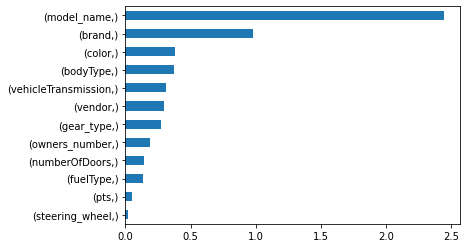

In [43]:
# посмотрим значимость признаков (категориальные + бинарные)

imp_cat = Series(mutual_info_classif(train_data[cat_cols + bin_cols], train_data['price'], 
                                     discrete_features=True), index=[cat_cols + bin_cols])
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Мы видим, что модель и бренд автомобиля оказывает подавляющее влияние на стоимость автомобиля. Менее всего ПТС и руль. 

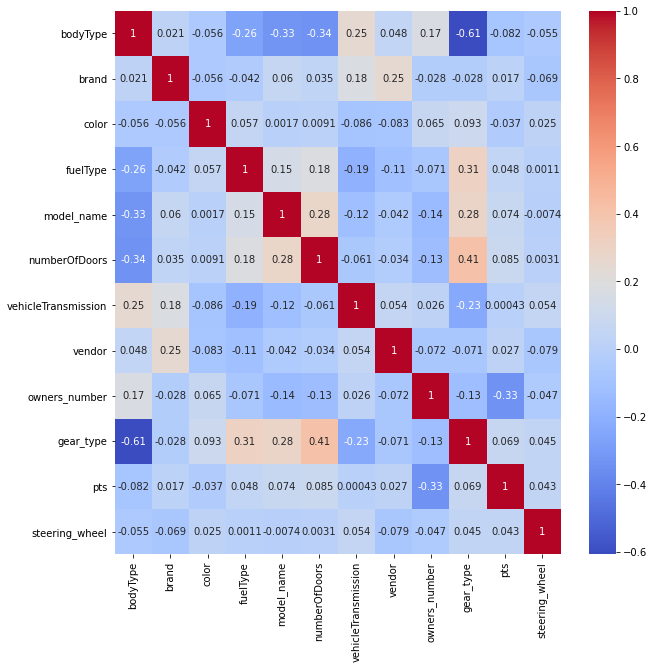

In [44]:
# корреляция

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.heatmap(train_data[cat_cols + bin_cols].corr(method='spearman'), 
                 annot=True, cmap='coolwarm')

Заметна корреляция между моделью автомобиля и кол-ом дверей / приводом. Привод также хорошо скоррелирован с типом кузов и кол-ом дверей соответственно. На основании указанных выше признаков можно будет попробовать собрать новый признак и посмотреть, как это скажется на качестве модели.

### num_cols

In [45]:
num_inspector = NumericInspector(data)

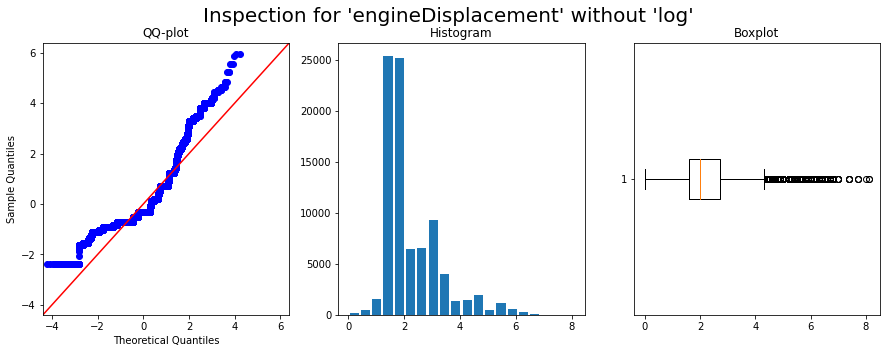

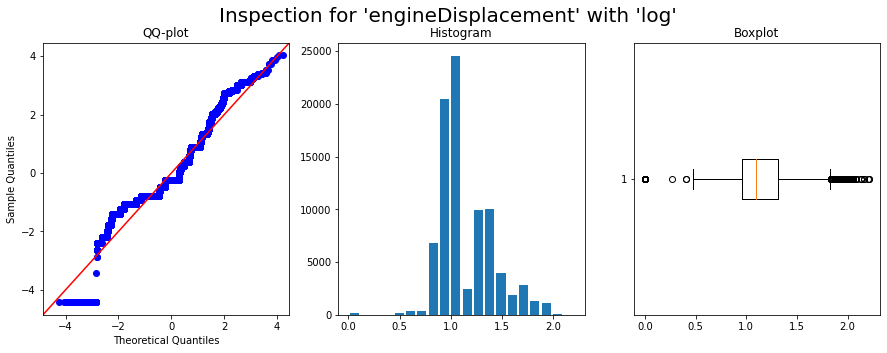

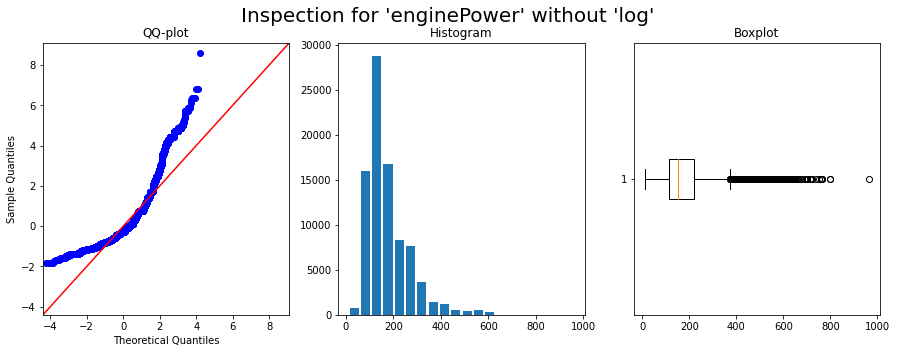

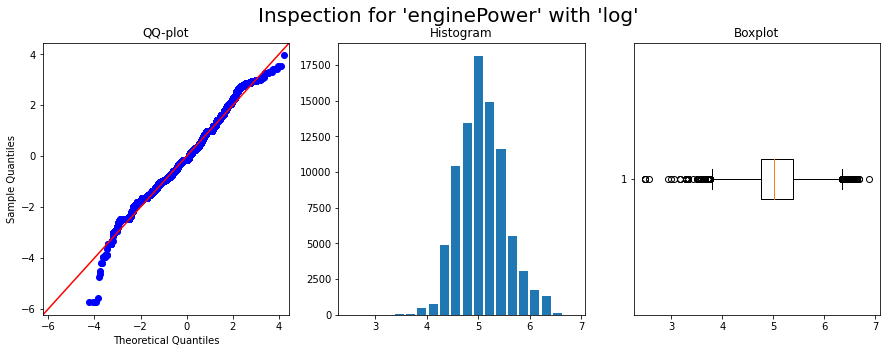

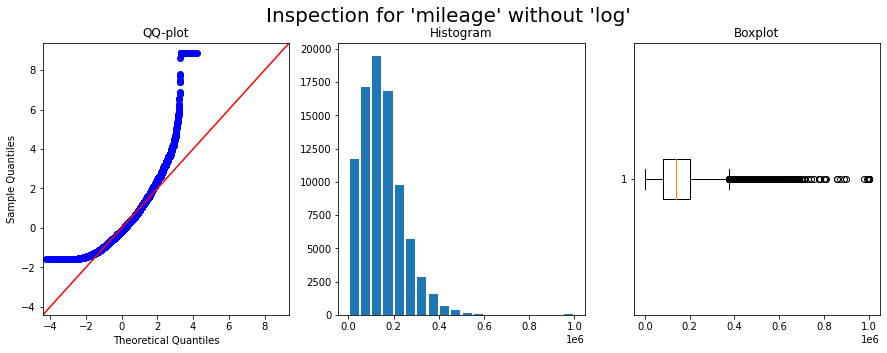

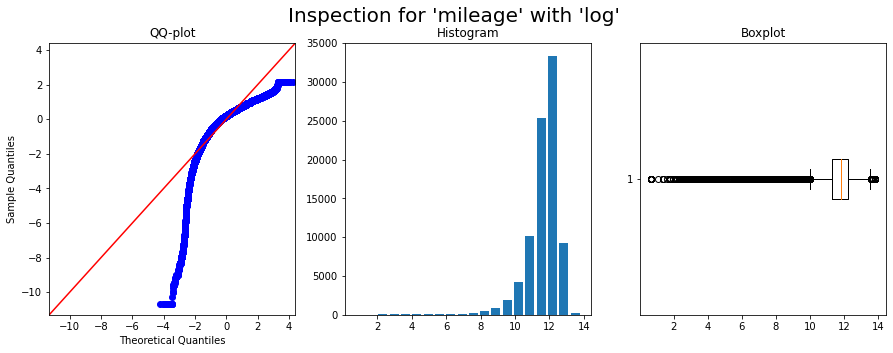

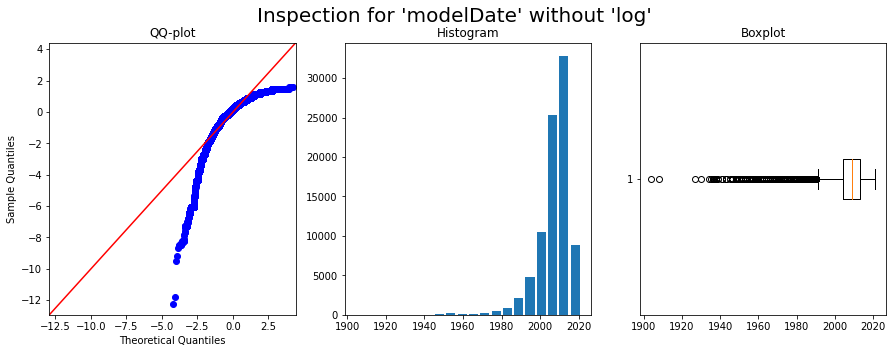

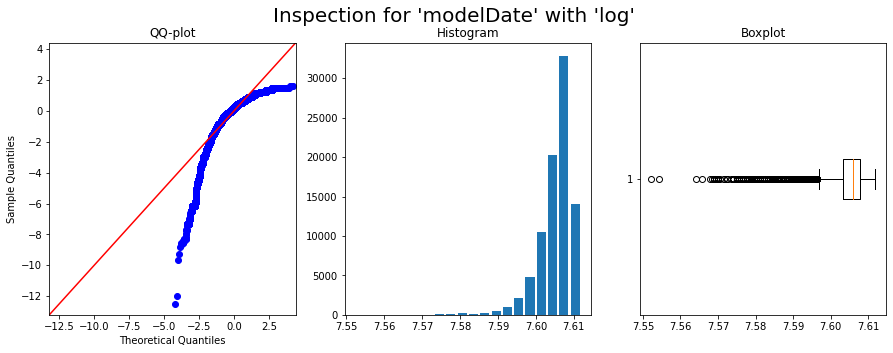

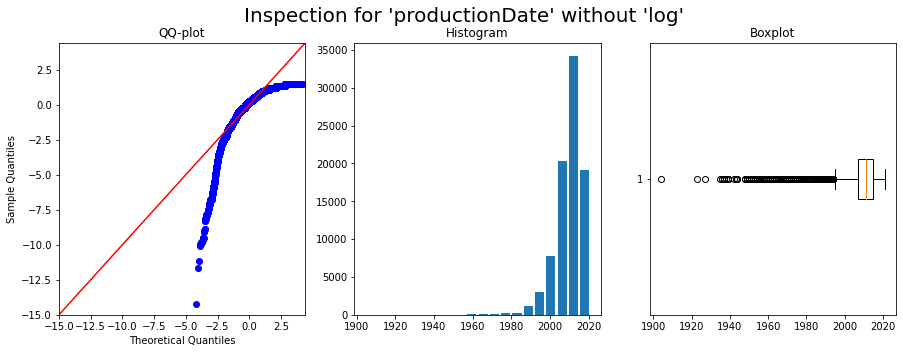

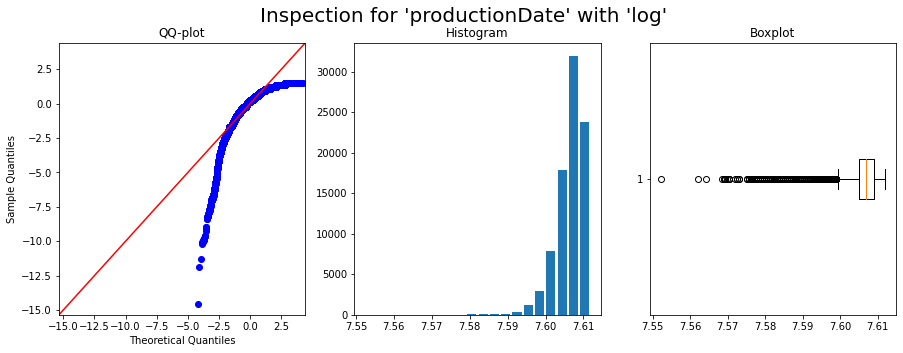

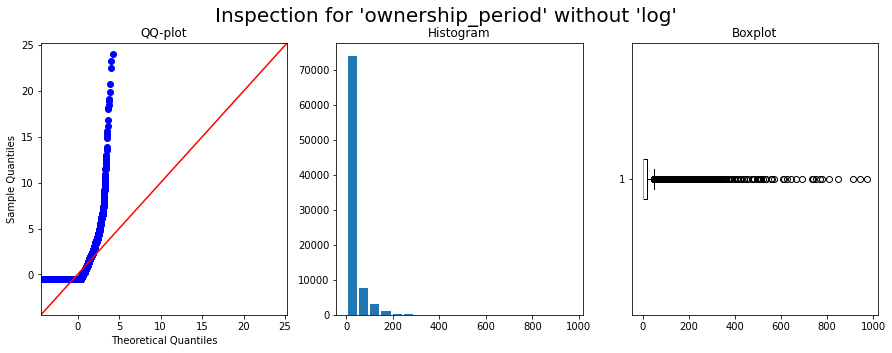

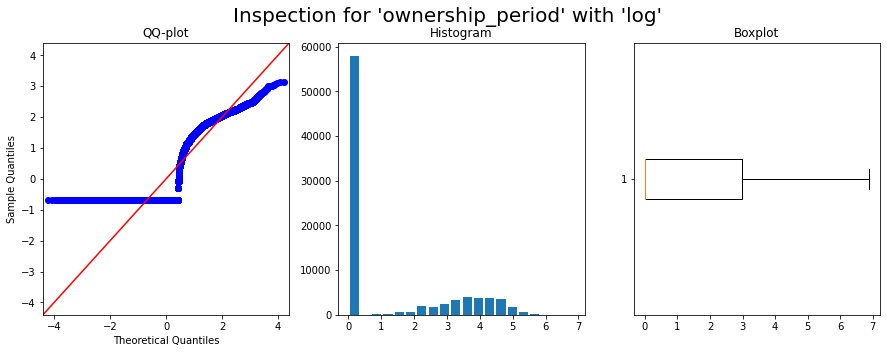

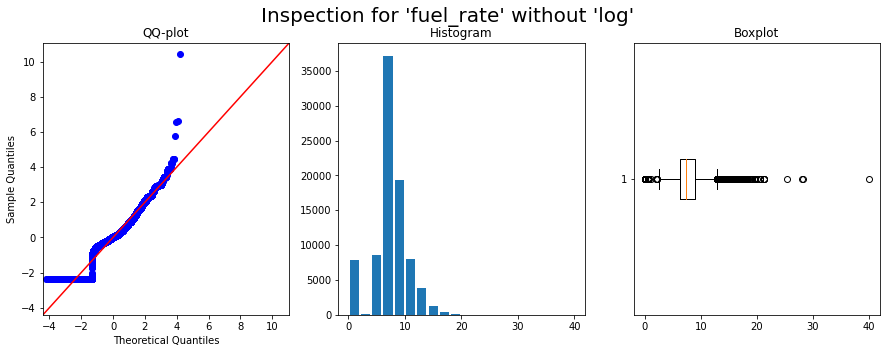

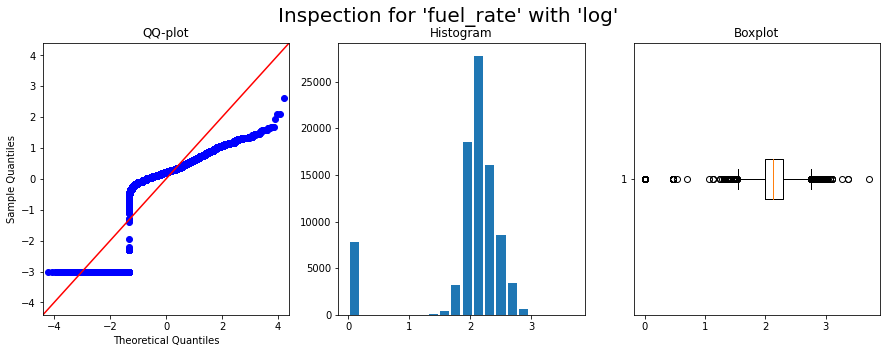

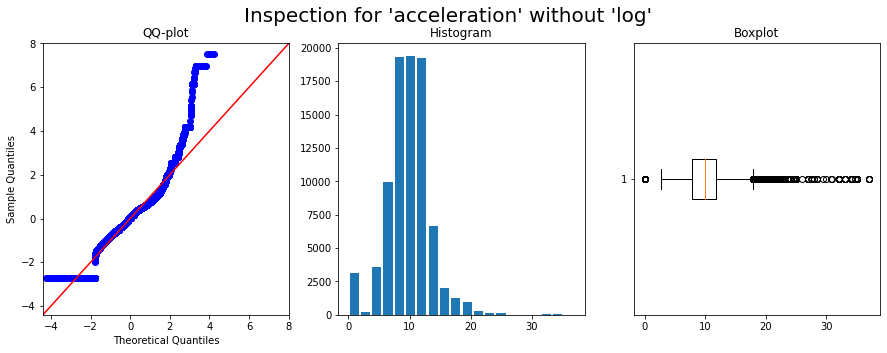

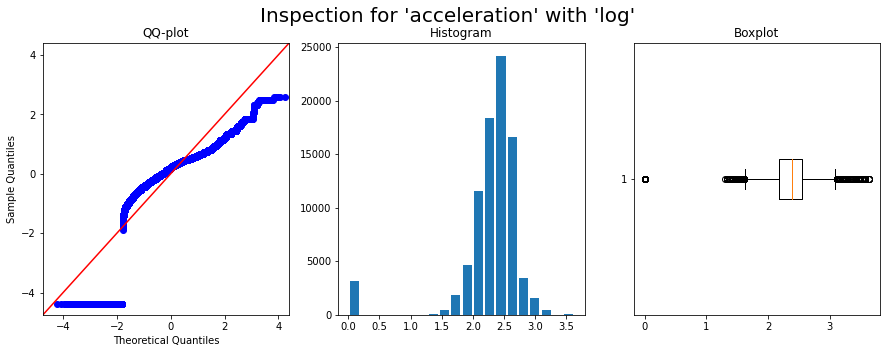

In [46]:
for col in num_cols:
    num_inspector.inspect(col)

#### ['engineDisplacement']

In [47]:
# посмотрим, сколько у нас нулевых значений

len(data[data['engineDisplacement'] == 0])

199

In [48]:
data['engineDisplacement'].describe()

count    86470.000000
mean         2.297138
std          0.970917
min          0.000000
25%          1.600000
50%          2.000000
75%          2.700000
max          8.100000
Name: engineDisplacement, dtype: float64

In [49]:
len(data.query('engineDisplacement >= 4.35'))

5290

In [50]:
# Создадим категориальный признак, признак электрокара, а также избавимся от выбросов.

data['is_electro'] = data['engineDisplacement'].apply(lambda x: 1 if x == 0 else 0)

In [51]:
# Создадим категориальный признак объема двигателя.

data['engineDisplacement_cat'] = data['engineDisplacement'].apply(lambda x: 1 if 0 <= x <=1.1 else 2 if 1.2 <= x <= 1.7
                                                                 else 3 if 1.8 <= x <= 3.5 else 4)

In [52]:
# работа с выбросами

data['engineDisplacement'] = data['engineDisplacement'].apply(lambda x: 4.35 if x >= 4.35 else x)

In [53]:
# Логарифмируем данные.

data['engineDisplacement'] = np.log(data['engineDisplacement'] + 1)

Сделаем тоже самое еще с двуми признаками: мощность двигателя и пробег.

#### ['enginePower']

In [54]:
data['enginePower'].describe()

count    86470.000000
mean       178.184122
std         91.530074
min         11.000000
25%        115.000000
50%        150.000000
75%        218.000000
max        963.000000
Name: enginePower, dtype: float64

In [55]:
len(data.query('enginePower >= 372.5'))

3781

In [56]:
# Создадим категориальный признак, избавимся от выбросов.

data['enginePower_cat'] = data['enginePower'].apply(lambda x: 1 if 0 <= x <= 70 else 2 if 71 <= x <= 100 
                                                    else 3 if 101 <= x <= 150 else 4 if 151 <= x <= 200
                                                   else 5)

In [57]:
# работа с выбросами

data['enginePower'] = data['enginePower'].apply(lambda x: 372.5 if x >= 372.5 else x)

In [58]:
# Логарифмируем данные

data['enginePower'] = np.log(data['enginePower'] + 1)

#### ['mileage']

In [59]:
data['mileage'].describe()

count      86470.000000
mean      150662.580699
std        95940.861145
min            1.000000
25%        82000.000000
50%       138202.000000
75%       200000.000000
max      1000000.000000
Name: mileage, dtype: float64

In [60]:
len(data.query('mileage >= 377000'))

2139

In [61]:
data['mileage_cat'] = data['mileage'].apply(lambda x: 1 if 0 <= x <= 100000 else 2 if 100001 <= x <= 300000 else 3)

#### ['modelDate'] / ['productionDate']

Эти два признака содержат выбросы, однако они имеют место быть. Логарифмирование не производим. 

In [62]:
# Создадим дополнительные признаки старого производства / модели на основании нижней границы выбросов.

data['is_old_model'] = data['modelDate'].apply(lambda x: 1 if x <= 1991 else 0)

data['is_old_prod'] = data['productionDate'].apply(lambda x: 1 if x <= 1995 else 0)

#### ['ownership_period']

Признак времени владения. Более 60% имеют нулевые значения - это связано с пропусками в данных. Теоретически невозможно, чтобы автомобиль б/у находился до этого во владении 0 месяцев. Попробуем выделить нулевые значения в отдельный признак - period_unknown, а нулевые значения в исходном признаке заменить на медианные. Экспериментально оценим, окажет ли это влияние на модель или нет. 

In [63]:
len(data.query('ownership_period == 0'))

57927

In [64]:
data['period_unknown'] = data.ownership_period.apply(lambda x: 1 if x == 0 else 0)

In [65]:
# преобразуем нули в пропуски, чтобы оценить распределение

data.ownership_period = data.ownership_period.apply(lambda x: None if x == 0 else x)

In [66]:
data.ownership_period.describe()

count    28543.000000
mean        55.734856
std         52.005347
min          1.000000
25%         20.000000
50%         41.000000
75%         79.000000
max        973.000000
Name: ownership_period, dtype: float64

In [67]:
# Заменим пропуски на медианное значение.

data.ownership_period = data.ownership_period.fillna(41)

In [68]:
# Логарифмируем данные.

data['ownership_period'] = np.log(data['ownership_period'] + 1)

#### ['fuel_rate'] / ['acceleration']

In [69]:
data.query('fuel_rate == 0').sample(10)

,bodyType,brand,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,modelDate,model_name,numberOfDoors,productionDate,sell_id,vehicleTransmission,vendor,owners_number,ownership_period,pts,gear_type,steering_wheel,sample,price,fuel_rate,acceleration,is_electro,engineDisplacement_cat,enginePower_cat,mileage_cat,is_old_model,is_old_prod,period_unknown
77139,0,113,11,None,- Более 150 автомобилей с пробегом в наличии!\...,1.386294,4.836282,"{'cruise-control': True, 'engine-proof': True,...",3,416000,1996,769,5,1997,1103005707,0,3,3,3.737670,1,2,1,1,643000.0,0.0,14.0,0,3,3,3,0,0,1
24146,17,117,13,None,"Редкий кузов doka, мотор 1.9 дизель, с докумен...",0.955511,4.262680,None,3,999999,1979,1264,3,1986,1101262915,2,2,1,3.737670,0,0,1,0,NaN,0.0,23.0,0,2,1,3,1,1,1
11990,11,84,15,None,"Приобретен автомобиль в 2010 у банка, была про...",1.098612,4.948760,"{'engine-proof': True, 'tinted-glass': True, '...",0,238000,1999,835,4,2005,1100642070,0,3,2,4.820282,1,1,1,0,NaN,0.0,12.3,0,3,3,2,0,0,0
51817,11,54,0,None,"Полностью на ходу, мотор стоит от Ваз 2107 инж...",0.916291,4.330733,{},0,36258,1967,120,4,1975,1103377226,2,5,1,3.737670,1,0,1,1,65000.0,0.0,19.0,0,2,2,1,1,1,0
7276,11,118,13,None,"Все расходники поменяны, установлен биксинон, ...",1.223775,5.141664,None,0,330000,2003,1085,4,2004,1093596102,0,2,3,3.737670,1,1,1,0,NaN,0.0,9.9,0,3,4,3,0,0,1
39706,11,11,12,None,"Торга нет, торга нет, торга нет! Хотите дешевл...",1.504077,5.463832,"{'cruise-control': True, 'tinted-glass': True,...",0,222222,1995,139,4,1997,1102907240,0,2,3,3.737670,0,0,1,1,239999.0,0.0,6.9,0,3,5,2,0,0,1
79325,8,113,15,None,"В 2014 году заказывал с Японии, состояние внеш...",1.223775,5.141664,"{'engine-proof': True, 'tinted-glass': True, '...",0,165000,2008,1305,5,2011,1103315618,1,3,1,4.406719,1,2,0,1,1550000.0,0.0,0.0,0,3,4,2,0,0,0
41933,18,21,4,None,Тест\n\nВаш выбор и Ваше время — наши главные ...,0.875469,4.553877,"{'condition': True, 'computer': True, 'airbag-...",0,183458,2003,251,5,2005,1103313844,0,0,2,3.737670,1,1,1,1,205000.0,0.0,11.9,0,2,2,2,0,0,1
58514,0,68,15,None,Бортжурнал на Drive2.ru — .https://www.drive2....,1.677097,5.726848,"{'engine-proof': True, 'tinted-glass': True, '...",0,330000,2002,252,5,2005,1101920720,0,0,3,4.584967,1,2,1,1,680000.0,0.0,7.6,0,4,5,3,0,0,0
40871,10,11,7,None,"Состояние идеальное, в ДТП не участвовала. Обс...",1.435085,5.774552,"{'navigation': True, 'computer': True, 'abs': ...",0,69000,1997,1416,2,2000,1102419979,2,2,2,5.463832,1,0,1,1,2500000.0,0.0,5.4,0,3,5,1,0,0,0


Судя по данным, нулевое значение расхода на связано с принадлежностью к эектрокарам. В таком случае - это пропуски. Попробуем их заполнить медианой.

In [70]:
data.fuel_rate.describe()

count    86470.000000
mean         7.387813
std          3.131371
min          0.000000
25%          6.300000
50%          7.400000
75%          8.900000
max         40.000000
Name: fuel_rate, dtype: float64

In [71]:
data.acceleration.describe()

count    86470.000000
mean         9.841549
std          3.616121
min          0.000000
25%          7.800000
50%          9.900000
75%         11.800000
max         37.000000
Name: acceleration, dtype: float64

In [72]:
data['fuel_rate'] = data['fuel_rate'].apply(lambda x: 7.4 if x == 0 else x)

In [73]:
# работа с выбросами

data['fuel_rate'] = data['fuel_rate'].apply(lambda x: 2.4 if x <= 2.4 else x)
data['fuel_rate'] = data['fuel_rate'].apply(lambda x: 12.8 if x >= 12.8 else x)

In [74]:
data['fuel_rate'] = np.log(data['fuel_rate'] + 1)

In [75]:
data['acceleration'] = data['acceleration'].apply(lambda x: 9.9 if x == 0 else x)

In [76]:
data['acceleration'] = np.log(data['acceleration'] + 1)

In [77]:
# выделим часть train и посмотрим значимость признаков

train_data = data.query('sample == 1').drop(['sample'], axis=1)

In [78]:
cat_cols.extend(['engineDisplacement_cat', 'enginePower_cat', 'mileage_cat'])
bin_cols.extend(['is_electro', 'period_unknown'])

<AxesSubplot:>

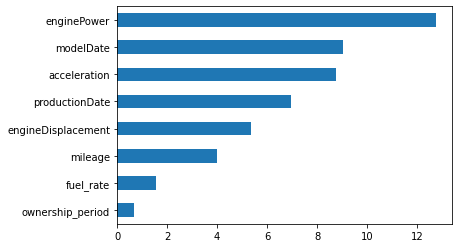

In [79]:
# посмотрим значимость признаков

imp_num = Series(f_classif(train_data[num_cols], train_data['price'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

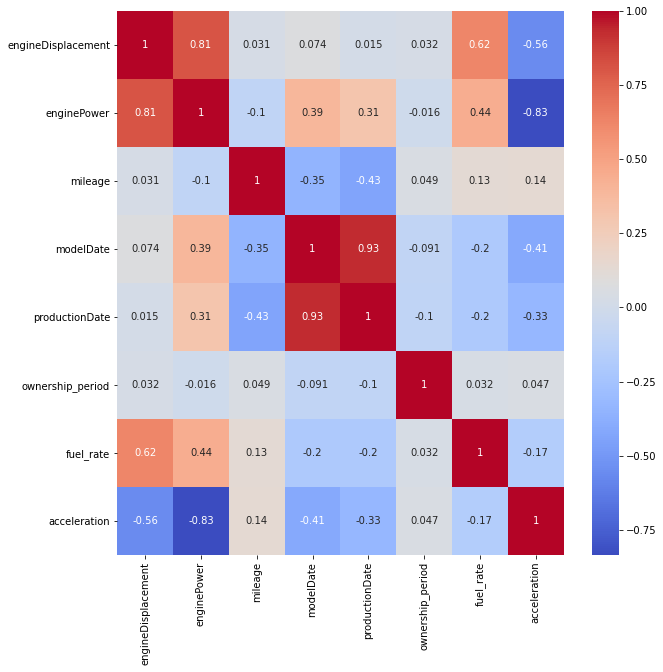

In [80]:
# корреляция

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.heatmap(train_data[num_cols].corr(), 
                 annot=True, cmap='coolwarm')

<AxesSubplot:>

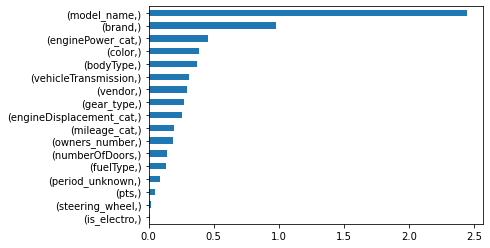

In [81]:
# посмотрим значимость признаков с учетом добавленных категориальных

imp_cat = Series(mutual_info_classif(train_data[cat_cols + bin_cols], train_data['price'], 
                                     discrete_features=True), index=[cat_cols + bin_cols])
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

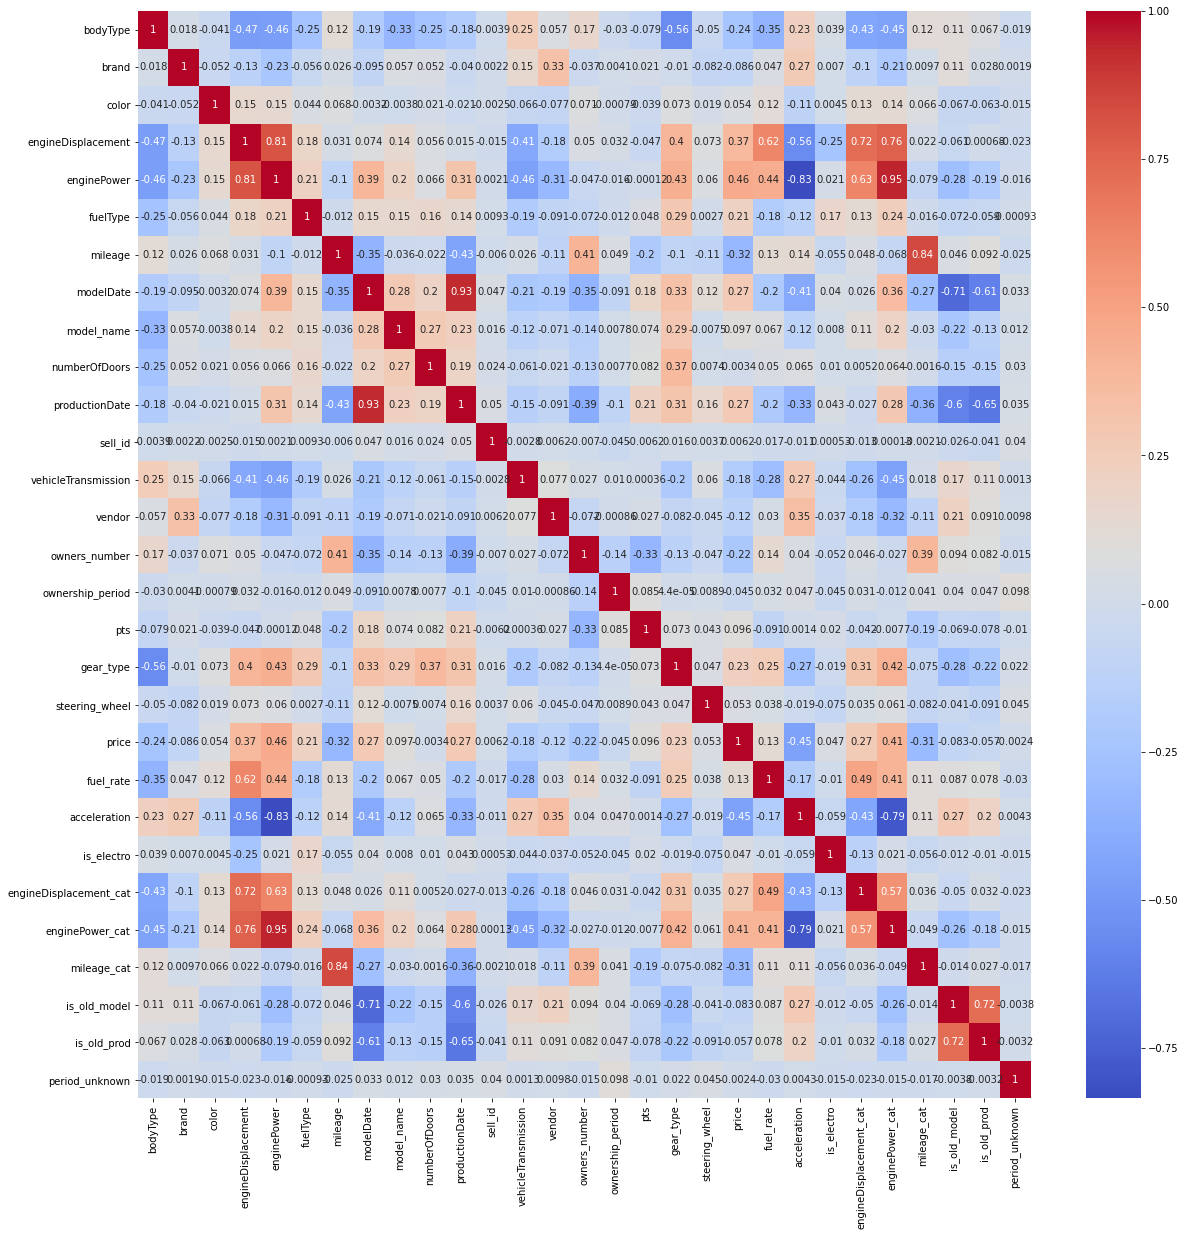

In [82]:
# Посмотрим общую корреляцию

fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax = sns.heatmap(train_data.corr(), 
                 annot=True, cmap='coolwarm')

In [83]:
# создадим новый признак на основании тех, что зависимы между собой и с целевой переменной

data['body_model_door_gear'] = (data['bodyType'] + data['model_name']) * data['gear_type'] + (2*data['numberOfDoors'])

#### ['description']

В рамках обработки признака описания были выделены самые часто используемые слова и экспериментальным методом добавлен бинарный признак наличия слова в описании, улучшающий искомую метрику.

In [84]:
# преобразуем в нижний регистр, заполним пропуски
data.description = data.description.apply(lambda x: x.lower() if type(x) == str else x)
data.description = data.description.fillna('ничего')

# проанализируем, выделив слова 
analyzer = CountVectorizer().build_analyzer()
docs = []
for document in data.description:
    docs.append(analyzer(document))

# соберем слова в единый список, отфильтров короткие (чаще - предлоги, союзы)
all_words = []
for i in docs:
    for x in i:
        if len(x) > 3:
            all_words.append(x)
            
            
c = collections.Counter() # Введем переменную для подсчета объектов с помощью модуля collections.

# Пройдемся циклом и подсчитаем количество значений для каждого слова. Посмотрим самые часто встречающиеся
for i in all_words:
    c[i] += 1
print(c.most_common(50))


[('автомобиль', 67599), ('автомобиля', 60117), ('пробегом', 47943), ('система', 43822), ('автомобилей', 32525), ('автомобили', 31327), ('состоянии', 30719), ('более', 27759), ('кредит', 27309), ('авто', 27107), ('машина', 24788), ('есть', 24448), ('салон', 23877), ('вашего', 20811), ('безопасности', 19750), ('сидений', 19311), ('комплектация', 18668), ('руля', 18441), ('года', 18301), ('торг', 18273), ('диски', 17577), ('день', 17443), ('обогрев', 17071), ('водителя', 16939), ('салона', 16697), ('рольф', 16683), ('контроль', 16657), ('зеркал', 16655), ('комплект', 16407), ('передние', 16369), ('покупке', 16263), ('обслуживание', 15960), ('только', 15912), ('дилера', 15810), ('пробег', 15796), ('подушки', 15444), ('фары', 15437), ('юридической', 15383), ('чистоты', 14174), ('датчик', 14033), ('официального', 14013), ('оригинал', 13517), ('подогрев', 13466), ('обмен', 13349), ('пассажира', 13212), ('выкуп', 13180), ('каско', 13082), ('климат', 12531), ('гарантия', 12343), ('отличном', 12

In [85]:
# добавим новый признак
data['word_каско'] = data['description'].apply(lambda x: 1 if 'каско' in x else 0)

### Выводы

Представленные выше графики построены для разведывательного анализа данных. Мы видим, что на цену автомобиля больше всего влияют следующие признаки: объем двигателя, его мощность, пробег, разгон, год производства. Название модели и тип топлива также важны для цены. Между model_date и production_date существует сильная корреляция - один из признаков, вероятно, будет убран.
Чтобы отслеживать, насколько то или иное дальнейшее изменение полезно для модели, построим изначально наивную модель и посмотрим метрику mape.
На основании проведенного выше анализа данных, предлагается далее провести эксперименты с данными (отбор признаков, эксперименты со сглаживанием выбросов, добавление новых на основании имеющихся), опираясь на изменения в метриках модели.
Далее необходимо построить модели с учетом подбора гиперпараметров, отбором признаков и стекингом.
При построении модели, вероятно, будет необходимо делать логарифмирование целевой переменной.

## Naive model
Эта модель будет предсказывать среднюю цену по модели двигателя (engineDisplacement). C ней будем сравнивать другие модели.

In [86]:
train_data = data.query('sample == 1').drop(['sample', 'complectation_dict', 'description', 'equipment_dict'], axis=1)
X = train_data.drop(['price'], axis=1)
y = train_data['price']

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

In [88]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [89]:
# Находим median по экземплярам engineDisplacement в трейне и размечаем тест
predict = X_test['engineDisplacement'].map(tmp_train.groupby('engineDisplacement')['price'].median())

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 99.27%


## Model experiments
В рамках дальнейшей работы были проведены эксперименты с построением следующих моделей:

- Linear Regression
- Random Forest Regressor
- Extra Trees Regressor
- Decision Tree Regressor
- Kneigbors
- AdaBoost
- GradientBoosting
- XGBoost
- CatBoost

В финальном ноутбуке эксперименты не отражены для оптимизации рабочего пространства. Наилучшие результаты показали:

- Random Forest, Extra Trees, XGBoost, CatBoost

Также были проведены эксперименты с разной стандартизацией признаков. Оптимальным оказался выбор StandardScaler. Дополнительно были проведены эксперименты с введением новых признаков, включая полиноминальные. Однако это ухудшило качество модели, поэтому было принято решение отказаться от данных признаков и не указывать их в финальном ноутбуке.

## Stacking

В рамках стекинга были проведены эксперименты по подбору моделей estimators (до 4 estimators) и мета-модели с разными параметрами, порядком и т.д. Наилучшие результаты показал указанный ниже стекинг.

Дополнительно был проведен отбор признаков. Был испробован метод отбора признаков с помощью SelectKBest, однако ручной отбор показал лучшие результаты.

In [90]:
# избавимся от лишнего
train_data = data.query('sample == 1').drop(['sample', 'complectation_dict', 'description', 
                                             'equipment_dict', 'productionDate', 'is_old_model',
                                            'engineDisplacement_cat', 'vehicleTransmission'], axis=1)
X = train_data.drop(['price'], axis=1)
y = train_data['price']

# разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

# проведем стандартизацию
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

In [91]:
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

### Поиск наилучших параметров для моделей

С помощью RandomizedSearchCV был произведен подбор параметров. Однако в дальнейшем параметры немного корректировались вручную, что улучшило результат по метрике.

In [92]:
# # Поиск лучших параметров для CatBoostRegressor (поиск занимает очень большой промежуток времени)

# model = CatBoostRegressor(
#     random_seed=RANDOM_SEED,
#     eval_metric='MAPE',
#     custom_metric=['MAE'],
#     silent=True,
#     task_type='GPU'
# )

# grid = {
#     'learning_rate': [0.03, 0.05, 0.1],
#     'depth': [2, 4, 6],
#     'l2_leaf_reg': [1, 3, 5, 7, 9],
#     'iterations': [int(x) for x in np.linspace(start=1000, stop=5000, num=20)]
# } 

# grid_search_result = model.grid_search(
#     grid,
#     X=X_train_st,
#     y=np.log(y_train),
#     plot=True
# )

In [93]:
# Общий метод для SkLearn регрессоров

def find_best_params(estimator, parameters, x_train, y_train):
    grid = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=parameters,
        random_state=RANDOM_SEED,
        n_iter=100,
        verbose=10,
        n_jobs=2
    )

    grid.fit(x_train, y_train)
    
    print("Best params:", grid.best_params_)
    print("Best score:", grid.best_score_)

In [94]:
# # Поиск лучших параметров для XGBRegressor (поиск занимает очень большой промежуток времени)

# find_best_params(
#     estimator=xgb.XGBRegressor(colsample_bytree=0.5, alpha=1),
#     parameters={
#         'learning_rate': [0.01, 0.05, 0.1],
#         'max_depth': [1, 3, 5, 7, 10],
#         'min_child_weight': [1, 3, 5],
#         'subsample': [0.5, 0.7],
#         'colsample_bytree': [0.5, 0.7],
#         'objective': ['reg:squarederror'],
#         'n_estimators': [int(x) for x in np.linspace(start=1000, stop=2000, num=5)]
#     },
#     x_train=X_train_st,
#     y_train=np.log(y_train)
# )

### Финальное обучение

In [95]:
# Поиск параметров занимает очень длительный промежуток времени и требует больших вычислительных мощностей ноутбука, 
# поэтому финальный код оформлен как комментарий

# estimators = [
#     ('cat_boost', CatBoostRegressor(
#         random_seed=RANDOM_SEED,
#         eval_metric='MAPE',
#         iterations=4200,
#         l2_leaf_reg=4,
#         depth=7,
#         custom_metric=['MAE'],
#         loss_function='RMSE',
#         learning_rate=0.08,
#         verbose=1
#     ))
# ]

# reg = StackingRegressor(
#     estimators=estimators,
#     cv=cv,
#     verbose=10,
#     passthrough=True,
#     n_jobs=-1,
#     final_estimator=xgb.XGBRegressor(
#         objective='reg:squarederror',
#         colsample_bytree=0.5,
#         learning_rate=0.03,
#         max_depth=11,
#         alpha=1,
#         n_jobs=-1,
#         n_estimators=1200,
#         seed=RANDOM_SEED
#     )
# )

# reg.fit(X_train_st, np.log(y_train))
# y_pred = np.exp(reg.predict(X_test_st))

# print(f"Точность модели по метрике MAPE: {(mape(y_test, y_pred))*100:0.2f}%")

**Итоговоая точность модели по метрике MAPE составила 16.73%**
### Итог:
В результате работы над данными:

- был произведен парсинг данных с auto.ru
- был произведен разведывательный анализ данных
- созданы новые признаки
- отбраны признаки для модели по значимости
- произведены эксперименты по подбору модели
- произведены эксперименты по стекингу
- подобраны оптимальные гиперпараметры для модели

В результате преобразований и в сравнении с наивной моделью заметны значительные улучшения предсказательной способности созданной модели.

## Submission

In [ ]:
X_sub = data.query('sample == 0').drop(['sample', 'complectation_dict', 'description', 
                                             'equipment_dict', 'productionDate', 'is_old_model',
                                            'engineDisplacement_cat', 'vehicleTransmission', 'price'], axis=1)

In [ ]:
X_sub = scaler.transform(X_sub)

В связи с тем, что данные для тестовой выборки были собраны раньше, чем для обучающей, логично предположить, что за это время рынок цен претерпел изменения. Экспериментально был подобран коэффициент 0,85.

In [ ]:
predict_submission = np.exp(reg.predict(X_sub))*0.85

In [ ]:
sample_submission = pd.read_csv('sample_submission.csv')

In [ ]:
sample_submission['price'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)sample_submission['price'] = predict_submission